In [1]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Lambda, LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import copy
from scipy.spatial.distance import cosine as cosine_distance
from keras.models import model_from_json
from collections import Counter
import import_ipynb
import drawingGraph as G
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Using TensorFlow backend.


importing Jupyter notebook from drawingGraph.ipynb


In [2]:
def getIndexFromGraph(filename):
    index = int(filename.split('-')[0].replace('graph', ''))
    return index

In [3]:
def calculateGraphGroup(num_dict):
    for index, data in enumerate(all_data):
        loc = getIndexFromGraph(graph_group[index])
        num_dict[loc] += 1
    return num_dict

In [4]:
def getEmbeddingSum():
    sum_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index, data in enumerate(all_data):
        data = data.reshape(1, data.shape[0], data.shape[1])
        embedded = encoder.predict(data)
        loc = getIndexFromGraph(graph_group[index])
        sum_embedding[loc] += embedded.reshape(embedded.shape[1])
    return sum_embedding

In [5]:
def getEmbeddingAvg():
    avg_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    sum_embedding = getEmbeddingSum()
    for index in range(graph_length):
        avg_embedding[index] = sum_embedding[index] / num_dict[index]
    return avg_embedding

In [6]:
def getEmbeddingVector(index):
    data_index = []
    data = []
    counts = num_dict[index]
    for num, i in enumerate(graph_group):
        if index == getIndexFromGraph(i):
            data_index.append(num)
        if len(data_index) == counts:
            break
    for i in data_index:
        dt = all_data[i].reshape(1, all_data[i].shape[0], all_data[i].shape[1])
        dt = encoder.predict(dt)
        dt = dt.reshape(dt.shape[1])
        data.append(dt)
    return data

In [7]:
def getMode(values):
    values.sort()
    mode = Counter(values).most_common()
    maximum = mode[0][1]
    if maximum == 1:
        return values.mean()
    else:
        dt = []
        for m in mode:
            if maximum == m[1]:
                dt.append(m[0])
            else:
                break
        return np.array(dt).mean()

In [8]:
def getEmbeddingMode(): # 최빈값
    mode_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            mode_embedding[index][count] = getMode(values)
        mode_embedding[index] = np.array(mode_embedding[index])
    return mode_embedding

In [9]:
def getEmbeddingExceptMinMax():
    except_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            values.sort()
            except_embedding[index][count] =  values[1:-1].mean()
        except_embedding[index] = np.array(except_embedding[index])
    return except_embedding

In [10]:
def euclidean_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum(a-b) ** 2)

In [11]:
def getGraphOrder(dist):
    ordered = copy.deepcopy(dist)
    ordered.sort()
    
    names = []
    
    for item in ordered:
        for index, d in enumerate(dist):
            if item == d:
                names.append(index)#+1)
                break
    return names, ordered

In [12]:
def getDistFromEmbedding(distance_measure, embedding, obj):
    if embedding  == 'sum':
        embeddings = sum_embedding
    elif embedding == 'avg':
        embeddings = avg_embedding
    elif embedding == 'mode':
        embeddings = mode_embedding
    elif embedding =='except':
        embeddings = except_embedding
    
    dist = []
    for embed in embeddings:
        if distance_measure == 'euc':
            dist.append(euclidean_distance(obj, embed))
        else:
            dist.append(cosine_distance(obj, embed))
    return dist

In [32]:
def getTopData(n, datasets, names):
    data = []
    for n in names[:n+1]:
        data.append(datasets[n])
    return data

In [14]:
def draw(drawobj, drawobj_name, dir_name, save):
    for index, obj in enumerate(drawobj):
        G.drawGraph(dir_name, 'graph' + str(drawobj_name[index]), index, obj, save)

In [15]:
filename = input('filename: ')
json_file = open("model/"+filename+".json", "r")
loaded_model_json = json_file.read() 
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('model/weights_'+ filename + '.h5')

filename: lstm_autoencoder


W1004 13:25:54.497141 140248691046144 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 13:25:54.505805 140248691046144 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 13:25:54.547646 140248691046144 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1004 13:25:55.705078 140248691046144 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [16]:
sequence_type = input('type(bfs? dfs?): ')
if sequence_type == 'bfs':
    dir = './latest_sequence/bfs/*'
else:
    dir = './latest_sequence/dfs/*'

# file read
all_data = []
sequence_length = []
graph_group = []
for file in sorted(glob.glob(dir)):
    graph_group.append(file.split('/')[-1].replace('.txt', ''))
    datasets = []
    for f in open(file, 'r'):
        (u, v, w) = f[1:-2].split(',')
        datasets.append([int(u), int(v), float(w)])
    sequence_length.append(len(datasets))
    all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

type(bfs? dfs?): bfs


In [17]:
graph_length = len(glob.glob('./latest_graph_data/*'))
embedded_length = 64
embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]

In [18]:
lstm_autoencoder = loaded_model

In [19]:
encoder = Model(lstm_autoencoder.input, lstm_autoencoder.layers[2].output)

In [20]:
num_dict = { i:0 for i in range(graph_length)}

for index, data in enumerate(all_data):
    data = data.reshape(1, data.shape[0], data.shape[1])
    encoded = encoder.predict(data)
    loc = getIndexFromGraph(graph_group[index])
    num_dict[loc] += 1
    embedding[loc] += encoded.reshape(encoded.shape[1])    

In [21]:
num_dict = { i:0 for i in range(graph_length)}
num_dict = calculateGraphGroup(num_dict)

In [22]:
sum_embedding = getEmbeddingSum()
avg_embedding = getEmbeddingAvg()
mode_embedding = getEmbeddingMode()
except_embedding = getEmbeddingExceptMinMax()

In [23]:
#그래프 그리기 위해 각 그래프 그룹 가운데 하나씩 가져옴. (모든 노드에 대한 sequence 에서 하나의 노드 시퀀스만 가져오기) 
datasets = [[] for i in range(graph_length)]
for n, data in zip(graph_group, all_data):
    index = int(n.split('-')[0].replace('graph', ''))
    if len(datasets[index]) == 0:
        d = []
        for row in data:
            u, v, w = row
            d.append([int(u), int(v), float(w)])
        datasets[index] = d

In [24]:
#mode_obj_name = 'graph' + str(0)
#sum_obj_name = 

mode_obj = mode_embedding[0]
sum_obj = sum_embedding[0]
avg_obj = avg_embedding[0]
except_obj = except_embedding[0]

In [34]:
dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)

dist_sum_cos = getDistFromEmbedding('cos', 'sum', sum_obj)
names_sum_cos, ordered_sum_cos = getGraphOrder(dist_sum_cos)

dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)

dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)

In [35]:
dist_avg_euc = getDistFromEmbedding('euc', 'avg', avg_obj)
names_avg_euc, ordered_avg_euc = getGraphOrder(dist_avg_euc)

dist_sum_euc = getDistFromEmbedding('euc', 'sum', sum_obj)
names_sum_euc, ordered_sum_euc = getGraphOrder(dist_sum_euc)

dist_mode_euc = getDistFromEmbedding('euc', 'mode', mode_obj)
names_mode_euc, ordered_mode_euc = getGraphOrder(dist_mode_euc)

dist_except_euc = getDistFromEmbedding('euc', 'except', except_obj)
names_except_euc, ordered_except_euc = getGraphOrder(dist_except_euc)

In [36]:
top10_mode_cos = getTopData(10, datasets, names_mode_cos)
back10_mode_cos = getTopData(10, datasets, names_mode_cos[::-1])

top10_sum_cos = getTopData(10, datasets, names_sum_cos)
back10_sum_cos = getTopData(10, datasets, names_sum_cos[::-1])

top10_avg_cos = getTopData(10, datasets, names_avg_cos)
back10_avg_cos = getTopData(10, datasets, names_avg_cos[::-1])

top10_except_cos = getTopData(10, datasets, names_except_cos)
back10_except_cos = getTopData(10, datasets, names_except_cos[::-1])

In [37]:
top10_mode_euc = getTopData(10, datasets, names_mode_euc)
back10_mode_euc = getTopData(10, datasets, names_mode_euc[::-1])

top10_sum_euc = getTopData(10, datasets, names_sum_euc)
back10_sum_euc = getTopData(10, datasets, names_sum_euc[::-1])

top10_avg_euc = getTopData(10, datasets, names_avg_euc)
back10_avg_euc = getTopData(10, datasets, names_avg_euc[::-1])

top10_except_euc = getTopData(10, datasets, names_except_euc)
back10_except_euc = getTopData(10, datasets, names_except_euc[::-1])

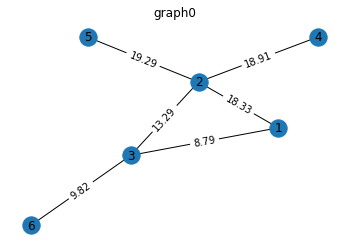

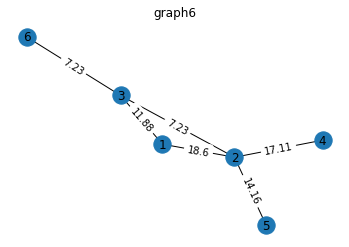

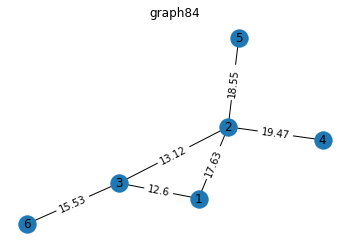

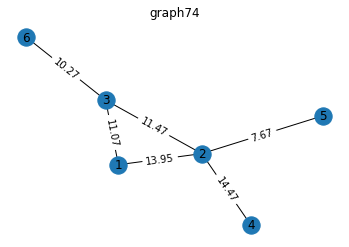

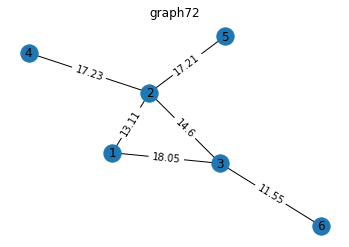

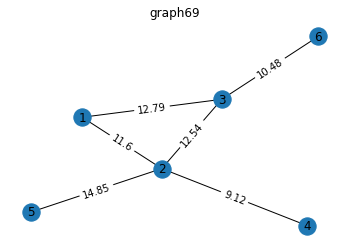

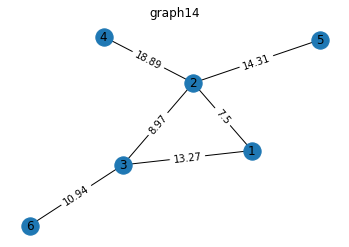

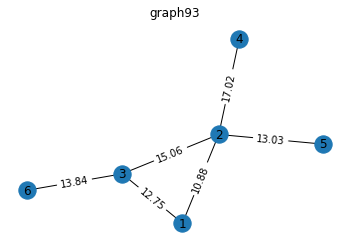

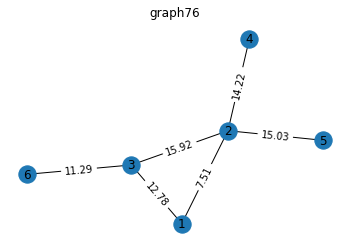

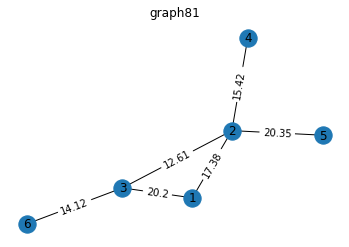

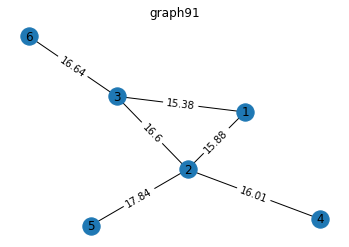

In [38]:
draw(top10_except_cos, names_except_cos, '', False)

In [88]:
# check top n results
count = 0
for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
    print(s, a, m, e)
    count += 1
    if count >= 21:
        break

0 0 0 0
6 6 84 6
84 84 91 84
72 72 98 74
74 74 79 72
93 93 81 69
14 14 93 14
90 90 96 93
69 69 82 76
66 66 92 81
98 98 69 91
81 81 85 83
76 76 66 90
91 91 62 71
85 85 72 98
96 96 76 66
83 83 65 85
71 71 90 99
79 79 14 70
99 99 71 79
82 82 89 82


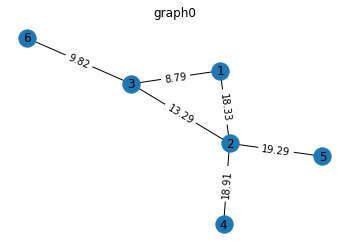

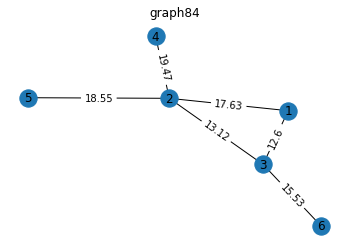

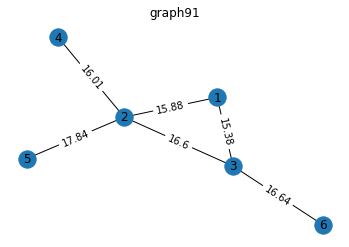

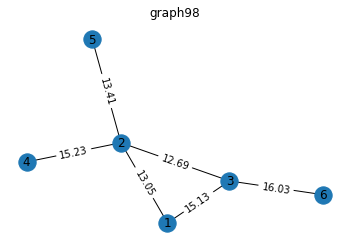

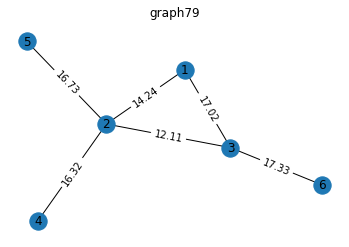

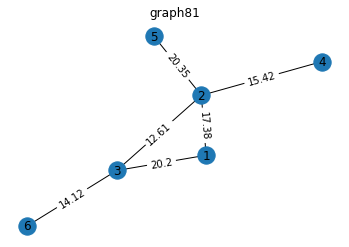

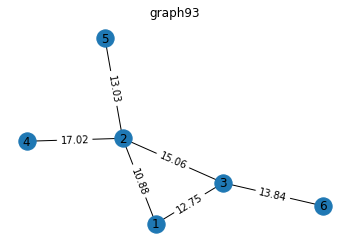

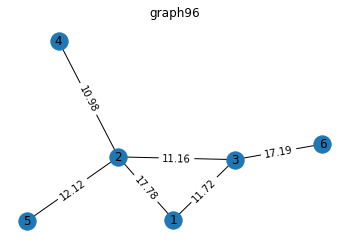

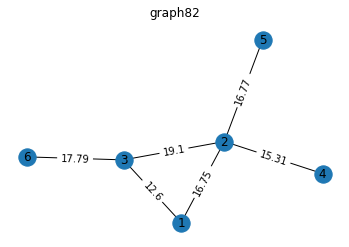

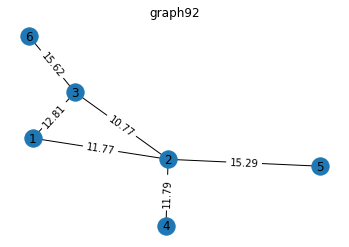

In [52]:
draw(top10_mode_cos, names_mode_cos, '', False)

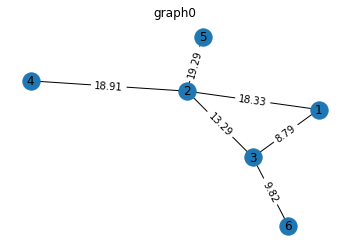

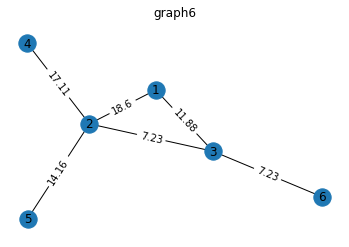

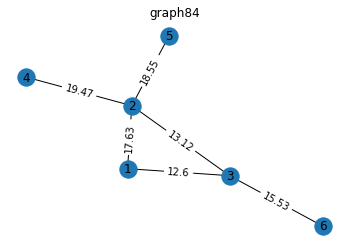

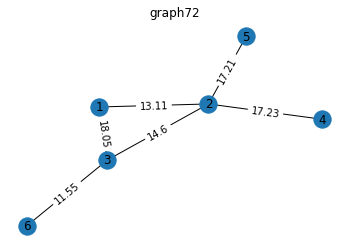

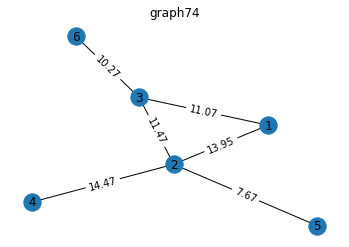

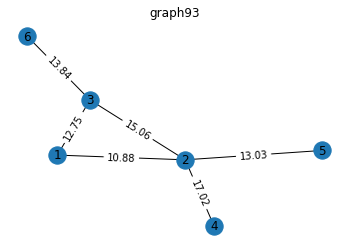

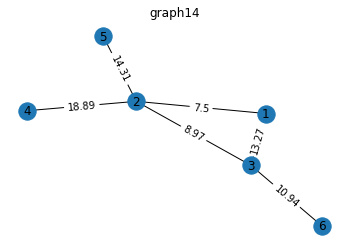

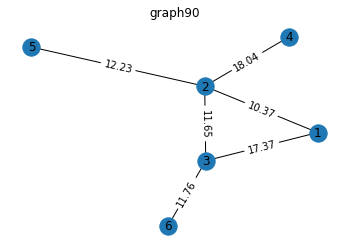

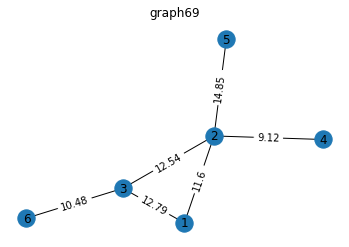

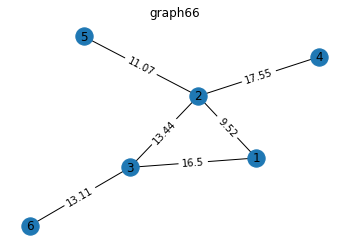

In [53]:
draw(top10_sum_cos, names_sum_cos, '', False)

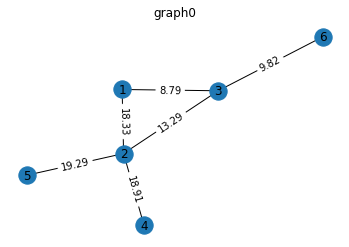

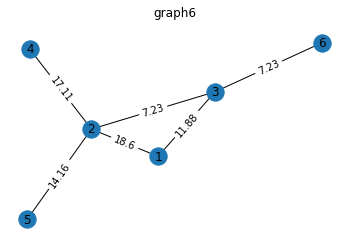

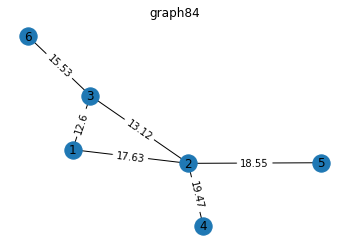

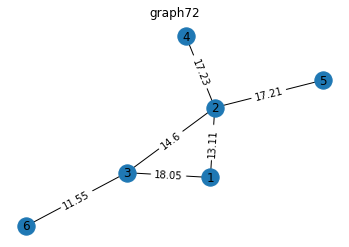

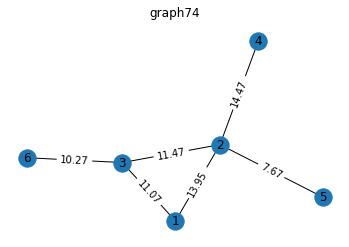

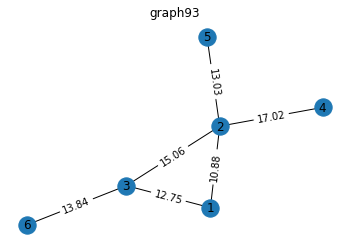

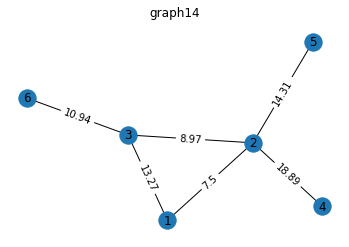

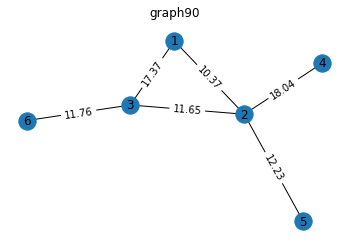

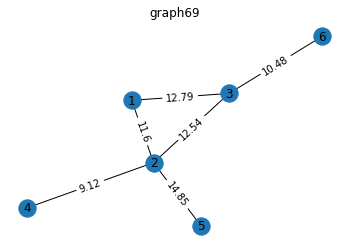

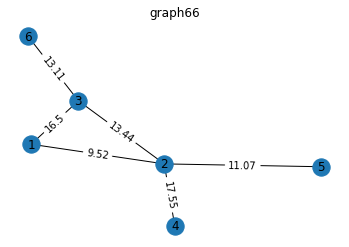

In [56]:
draw(top10_avg_cos, names_avg_cos, '', False)

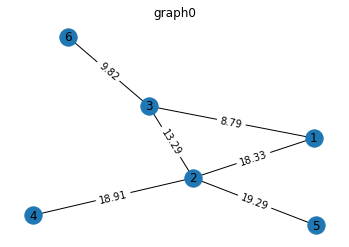

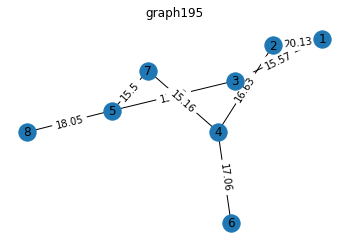

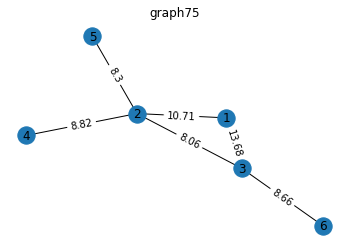

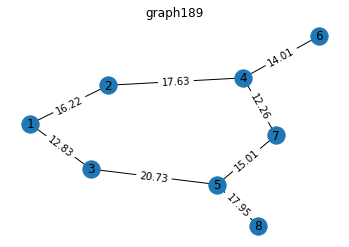

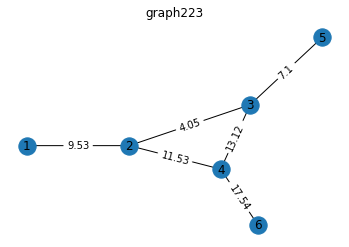

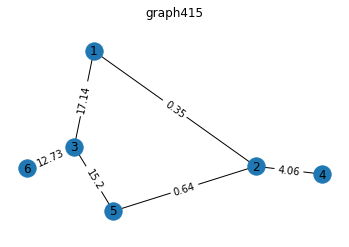

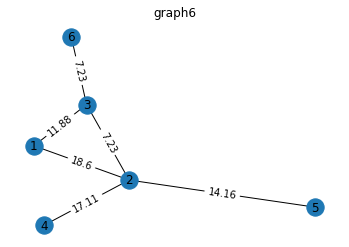

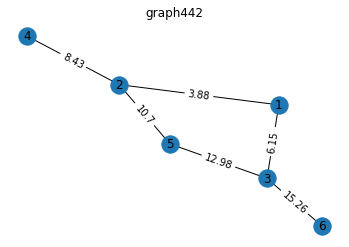

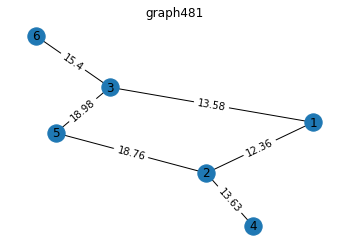

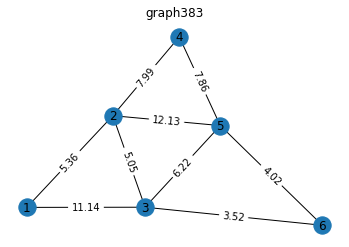

In [55]:
draw(top10_avg_euc, names_avg_euc, '', False)